# Рынок заведений общественного питания Москвы

Данный проект является учебным и выполнен в рамках курса "Ананлитик данных" на образовательной платформе Яндекс.Практикум. Датасет был предоставлен авторами курса. Недостающие данные собирались в него при помощи обращения к API Яндекс.Карт.

#### Описание проекта
Было принято решение открыть оригинальное кафе, где гостей обслуживают роботы. Проект многообещающий, но дорогой, необходимо привлечение инвестиций. Инвесторов интересует текущее положение дел на рынке. Необходимо определить где и в каком формате следует открывать кафе, чтобы обеспечить бизнесу жизнеспособность после спада первого интереса СМИ, блогеров и любителей роботов. В результате исследования была подготовлена презентация: https://drive.google.com/file/d/1Mupm9w5GPRAL8fgvjQsle83PLGHe8dQQ/view?usp=sharing

## План выполнения проекта

[Шаг 1. Загрузка данных и подготовка к анализу](#step1)

[Шаг 2. Анализ данных](#step2)

- [Соотношение видов объектов общественного питания по количеству](#par.1)

- [Соотношение сетевых и несетевых заведений по количеству](#par.2)

- [Объект общественного питания, для которого характерно сетевое распространение](#par.3)

- [Характерные черты сетевых заведений](#par.4)

- [Среднее количество посадочных мест](#par.5)

- [Поиск улицы](#par.6)

- [Топ-10 улиц по количеству объектов общественного питания. API Яндекс.Карт](#par.7)

- [Улицы с одним объектом общественного питания](#par.8)

- [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#par.9)

[Шаг 3. Презентация](#step3)

## <a id="step1">Шаг 1. Загрузка данных и подготовка к анализу</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

In [2]:
rest_data = pd.read_csv(r'L:\Data Analyst\8. Story/rest_data.csv')

In [3]:
rest_data.sample(5)

id           object_name chain object_type  \
9477   163950              СТОЛОВАЯ   нет    столовая   
5858    28057  Интертрансэкспедиция   нет        кафе   
1665    25308                   Ани   нет        кафе   
14998  216926          Кафе «Сахли»   нет  закусочная   
6707   147333           Бургер Кинг    да        кафе   

                                                 address  number  
9477   город Москва, Алтуфьевское шоссе, дом 31, стро...      80  
5858   город Москва, Иловайская улица, дом 2Б, строен...      80  
1665                город Москва, улица Руднёвка, дом 14      32  
14998  город Москва, поселение Десеновское, деревня В...      10  
6707         город Москва, Багратионовский проезд, дом 5      14

In [4]:
rest_data.duplicated().sum()

0

In [5]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Таблица rest_data состоит из 6 столбцов и 15366 строк и содержит следующие данные:

- object_name — название объекта общественного питания
- chain — сетевой ресторан
- object_type — тип объекта общественного питания
- address — адрес
- number — количество посадочных мест
В таблице нет дубликатов и пропущенных значений.

Объекты общественного питания названы везде по-разному, где-то со словом кафе, где-то без, где-то с маленькой буквы, где-то с большой. Также отличается тип заведения. Например, Макдональдс это и предприятие быстрого обслуживания, и кафе, и ресторан. И если различия в названиях не столь существенны для данного исследования, то вот типы заведения стоит заменить. Для этого сначала приведем все названия к единому виду, а потом найдем самый часто встречающийся тип заведения для каждого названия и запишем его как основной тип. Все эти преобразования мы будем делать только с сетевыми объектами. 

In [6]:
#приведем все названия к нижнему регистру
rest_data['object_name'] = rest_data['object_name'].str.lower()

In [7]:
#уберем кавычки
rest_data['object_name'] = rest_data['object_name'].str.replace('«','')
rest_data['object_name'] = rest_data['object_name'].str.replace('»','')

In [8]:
#разницу между кириллицей и латиницей преодолем вручную
rest_data.loc[rest_data['object_name'].str.contains('сабвей'), 'object_name']  = 'subway'
rest_data.loc[rest_data['object_name'].str.contains('старбакс'), 'object_name'] = 'starbucks'
rest_data.loc[rest_data['object_name'].str.contains('суши вок'), 'object_name'] = 'суши wok'
rest_data.loc[rest_data['object_name'].str.contains('прайм'), 'object_name'] = 'прайм стар'
rest_data.loc[rest_data['object_name'].str.contains('братья караваевы'), 'object_name'] = 'кулинарная лавка братьев караваевых'

In [9]:
#для всего остального запустим цикл, приводящий названия сетевых ресторанов к единому виду
chain_names = rest_data.query('chain == "да"')['object_name'].unique()
for name in chain_names:
    rest_data.loc[rest_data['object_name'].str.contains(name), 'object_name'] = name

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1952: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [10]:
rest_data.query('chain == "да"')['object_name'].value_counts().head(20)

kfc                                    188
шоколад                                187
макдоналдс                             173
бургер кинг                            159
кофе                                   134
теремок                                111
домино'с пицца                          99
крошка картошка                         96
суши wok                                90
милти                                   81
starbucks                               68
папа джонс                              67
subway                                  60
прайм стар                              60
хинкальная                              54
додо пицца                              54
чайхона №1                              52
якитория                                50
тануки                                  47
кулинарная лавка братьев караваевых     35
Name: object_name, dtype: int64

Отлично, дубликаты названий пропали, но вот сеть "Шоколадница" превратилась в кафе "Шоколад", что находится на проспекте Вернадского. Исправим эту ошибку.

In [11]:
rest_data['object_name'] = rest_data['object_name'].str.replace('шоколад','шоколадница')
rest_data['object_name'][169] = 'шоколад'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
#заменим тип объекта
new_chain_names = rest_data.query('chain == "да"')['object_name'].unique()
for name in new_chain_names:
    rest_data.loc[rest_data['object_name'] == name, 'object_type'] = rest_data.loc[rest_data['object_name'] == name, 'object_type'].mode()[0]

### Вывод

Произведен первый взгляд на данные, названия сетевых объектов общественного питания были приведены к единому виду, также был заменен тип объекта на самый часто упоминаемый для каждого названия сетевого заведения. 

## <a id="step2">Шаг 2. Анализ данных</a>

### <a id="par.1">Соотношение видов объектов общественного питания по количеству</a>

In [13]:
type_of_rest = rest_data.groupby('object_type')['id'].count().reset_index().sort_values('id', ascending=False)
type_of_rest

object_type    id
3                               кафе  6444
8                           столовая  2570
7                           ресторан  2128
6  предприятие быстрого обслуживания  2066
0                                бар   822
1                              буфет   571
2                         закусочная   300
4                          кафетерий   271
5          магазин (отдел кулинарии)   194

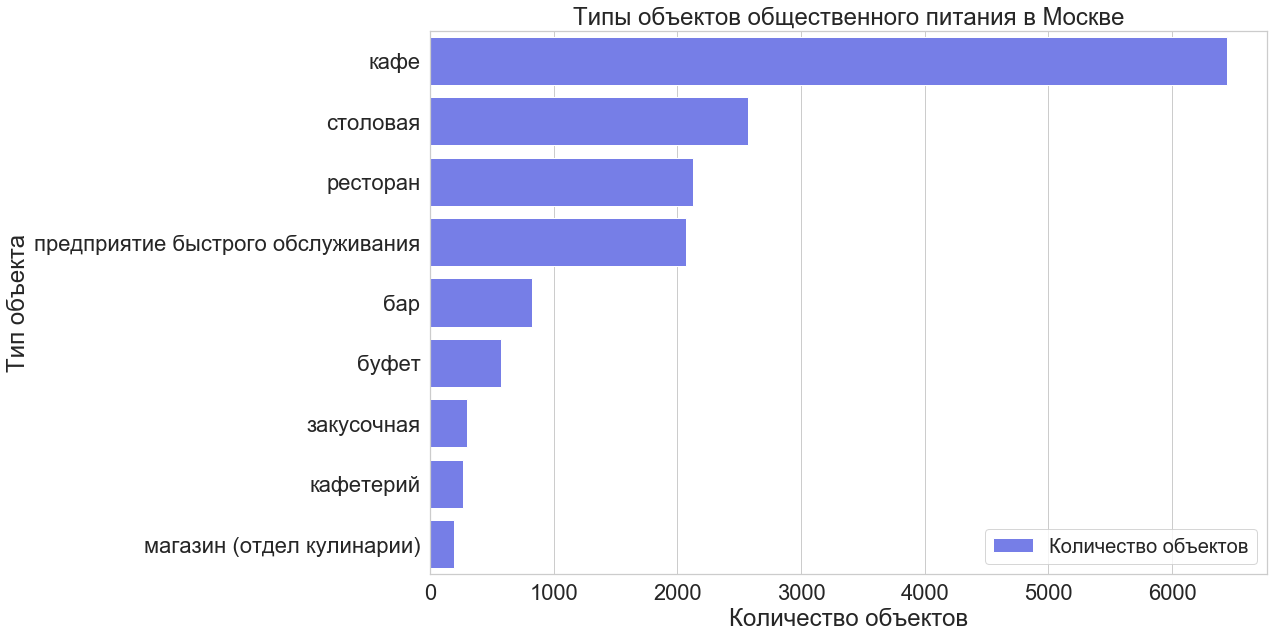

In [14]:
sns.set(style='whitegrid', font_scale=2)
f, ax = plt.subplots(figsize = (15, 10))
sns.barplot(x='id', y='object_type', data=type_of_rest, label='Количество объектов', color='#636efa')
ax.legend(ncol=2, loc='lower right', fontsize=20, frameon=True)
plt.title('Типы объектов общественного питания в Москве')
plt.xlabel('Количество объектов')
plt.ylabel('Тип объекта')
plt.show()
f.savefig(r'L:\Data Analyst\8. Story/fname', dpi=300, transparent=True, bbox_inches="tight")

А ещё я научилась делать pie chart в этом спринте, поэтому очень хотелось добавить и его тоже, хотя bar chart нагляднее.

In [15]:
fig = px.pie(type_of_rest, values='id', names='object_type', color_discrete_sequence=px.colors.qualitative.Pastel1, title='Доля объектов общественного питания в Москве')
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.show()

### Вывод

Большинство заведений относится к категории “кафе”, т.к. в отличие от ресторанов, открытие кафе не требует серьезных материальных вложений. Приходя в кафе, гости не ожидают высшего класса обслуживания и авторской кухни. Скорее, они приходят за спокойным отдыхом, вкусными блюдами и аутентичной атмосферой.

Контролировать работу кафе значительно легче, особенно по сравнению с рестораном. Однако, для увеличения спроса и популярности среди гостей необходимо всегда “держать руку на пульсе”. Открывая кафе, необходимо продумать основные отличия от конкурентов.


### <a id="par.2">Соотношение сетевых и несетевых заведений по количеству</a>

In [16]:
chain_or_not = rest_data.groupby('chain')['id'].count().reset_index()

In [17]:
chain_or_not['chain'] = chain_or_not['chain'].str.replace('да','сеть')
chain_or_not['chain'] = chain_or_not['chain'].str.replace('нет','не сеть')

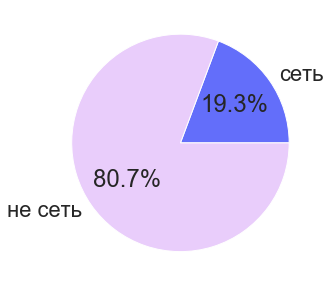

In [18]:
plt.figure(figsize=(5, 5))
plt.pie(chain_or_not['id'], labels=['сеть', 'не сеть'], colors=['#636efa', '#e9cdfb'], autopct='%1.1f%%')
plt.show()

### Вывод

Большинство объектов общественного питания Москвы не являются сетевыми. Перейти на следующую ступень и развить одно заведение в сеть достаточно сложно и не всегда экономически выгодно. Поэтому основатели ресторанов и аутентичных кафе, обычно не трансформируются в сеть, а открывают ещё одно другое, непохожее заведение. 

### <a id="par.3">Объект общественного питания, для которого характерно сетевое распространение</a>

In [19]:
object_types = rest_data['object_type'].unique()

In [20]:
rest_data['chain'] = rest_data['chain'].str.replace('да','сеть')
rest_data['chain'] = rest_data['chain'].str.replace('нет','не сеть')

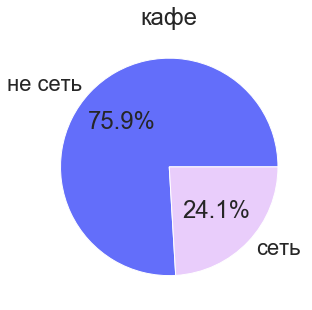

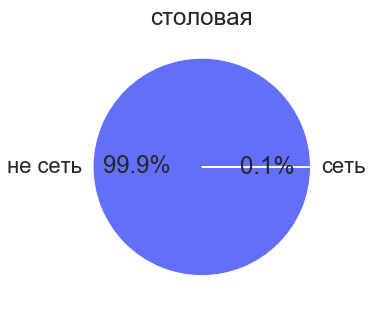

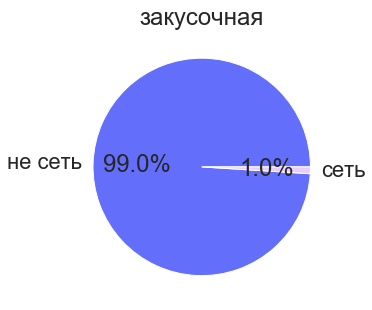

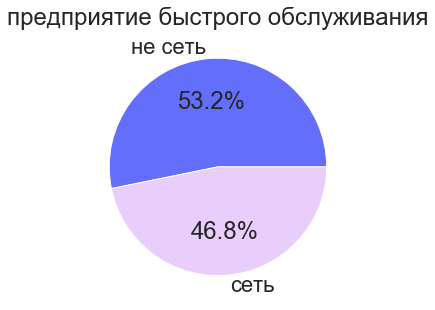

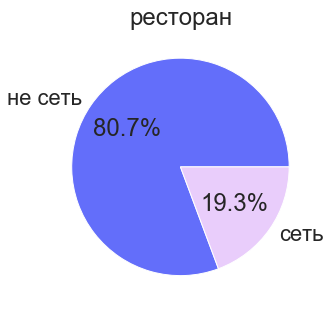

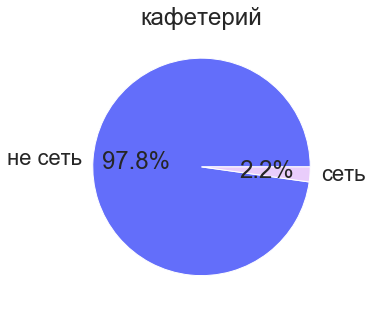

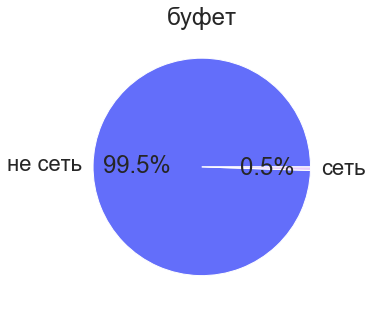

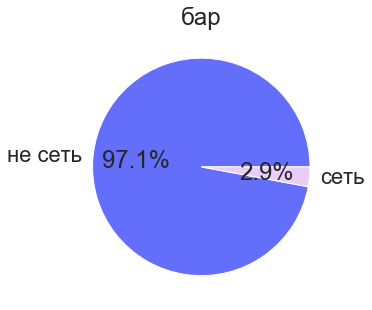

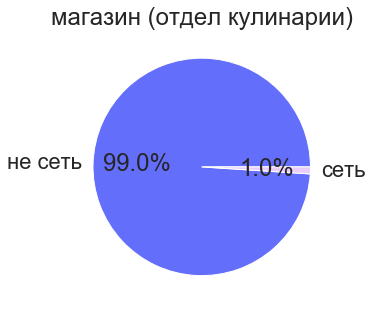

In [21]:
for object_type in object_types:
    data = rest_data[rest_data['object_type'] == object_type]
    chain_or_not = data.groupby('chain')['id'].count().reset_index()
    plt.figure(figsize=(5,5))
    plt.pie(chain_or_not['id'], labels=['не сеть', 'сеть'], colors=['#636efa', '#e9cdfb'], autopct='%1.1f%%')
    plt.title(str(object_type))
    plt.show()

### Вывод

Наиболее характерна сетевая форма распространения для предприятий быстрого обсуживания. Также нередки и сетевые рестораны и кафе, но всё же несетвые заведения доминируют на всех графиках, вне зависимости от типа объекта. 

### <a id="par.4">Характерные черты сетевых заведений</a>

In [22]:
chain_rest = rest_data.query('chain == "сеть"')

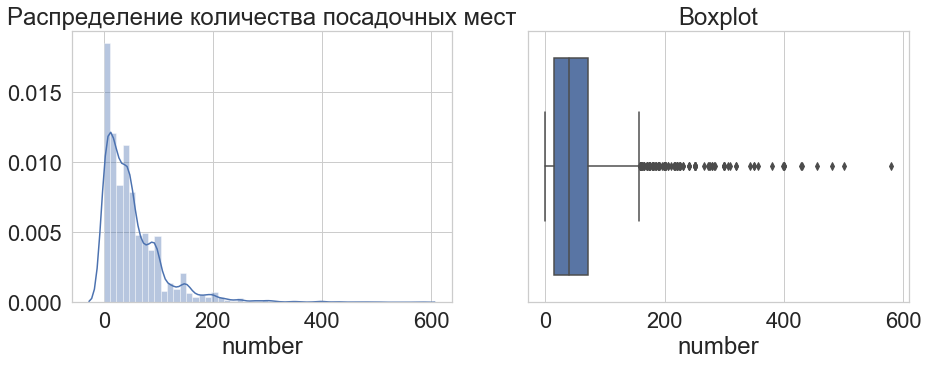

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2,  figsize = (15,5))
sns.distplot(chain_rest['number'], ax = ax[0]).set_title('Распределение количества посадочных мест')
sns.boxplot(chain_rest['number'], ax = ax[1]).set_title('Boxplot')
plt.show()

In [24]:
chain_rest['number'].describe()

count    2968.000000
mean       52.919811
std        57.140644
min         0.000000
25%        15.000000
50%        40.000000
75%        72.000000
max       580.000000
Name: number, dtype: float64

### Вывод

В сетевых заведениях как правило немного посадочных мест. Примерно в половине их меньше 40. Больше 150 мест вcтречается уже довольно редко, всего в 5% случаев. 

### <a id="par.5">Среднее количество посадочных мест</a>

In [25]:
seats_mean = rest_data.groupby('object_type')['number'].mean().astype('int').reset_index().sort_values('number', ascending=False)
seats_mean

object_type  number
8                           столовая     130
7                           ресторан     100
1                              буфет      52
0                                бар      44
3                               кафе      38
6  предприятие быстрого обслуживания      23
4                          кафетерий       9
2                         закусочная       6
5          магазин (отдел кулинарии)       4

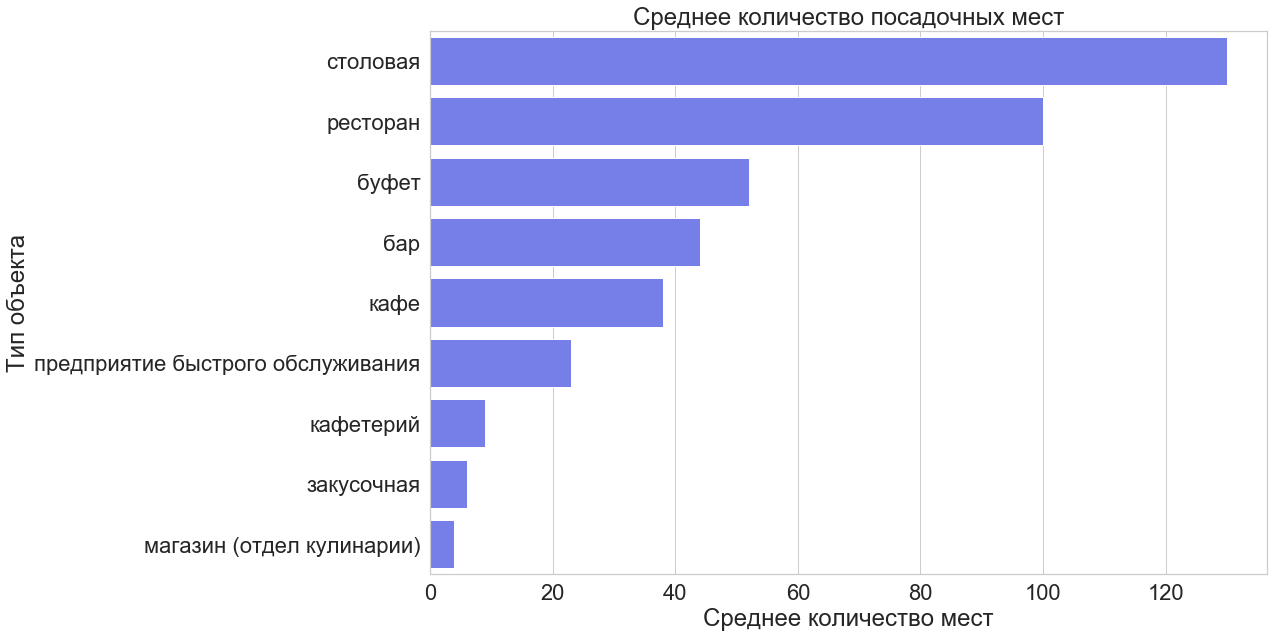

In [27]:
plt.subplots(figsize = (15, 10))
sns.barplot(x='number', y='object_type', data=seats_mean, label='Среднее количество мест', color='#636efa')
plt.title('Среднее количество посадочных мест')
plt.xlabel('Среднее количество мест')
plt.ylabel('Тип объекта')
plt.show()

### Вывод

В среднем больше всего посадочных мест в столовых и ресторанах. Столовые предназначены, для того чтобы накормить как больше людей. А многие рестораны не были бы рентабельны, если бы в них одновременно могло находиться небольшое количество гостей.

### <a id="par.6">Поиск улицы</a>

In [28]:
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия', 'квартал']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

rest_data['street'] = rest_data['address'].str.extract(str_pat, flags=re.I)

### Вывод

Названия улиц были выделены из адреса при помощи регулярного выражения

### <a id="par.7">Топ-10 улиц по количеству объектов общественного питания</a>

В следующем пункте, было необходимо не только найти топ-10 улиц по количеству объектов общественного питания, но и определить в каких районах они находятся. Посмотрев консультацию наставника я воспользовалась API Яндекс.Карт и подтянула к своему дата-сету сначала координаты места, а потом район города. Для 33 объектов не удалось определить координаты, и для 671 объекта остался не известен район. Т.к. это менее 5% нашего датасета, то такую неточность можно допустить. Обновленный файл с координатами и районами я загрузила на гугл диск.

In [29]:
#код для API Яндекс карт

'''
import requests
from yaml import load, FullLoader

API_URL = 'https://geocode-maps.yandex.ru/1.x'

config = load(open(r'L:\Data Analyst\8. Story/config.yaml'), Loader=FullLoader)
token = config['yandex_maps']['token']
'''
#напишем функцию, которая находит координаты места
'''
def fill_coordinates(cell):
    params = {
    'geocode': cell,
    'format': 'json',
    'apikey': token
    }
    for n in range(4):
        try:
            r = requests.get(API_URL, params=params)
            coordinates = r.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
            break
        except:
            coordinates = 'no result'   

    return coordinates
'''
#создадим новый столбец с координатами
'''
rest_data['coordinates'] = rest_data['address'].apply(fill_coordinates)
'''
#напишем функцию, которая находит район
'''
def fill_district(cell):
    params = {
    'geocode': ','.join(cell.split(' ')),
    'format': 'json',
    'apikey': token
    }
    for n in range(4):
        try:
            r = requests.get(API_URL, params=params)
            district = r.json()['response']['GeoObjectCollection']['featureMember'][2]['GeoObject']['metaDataProperty']['GeocoderMetaData']['Address']['Components'][5]['name']
            break
        except:
            district = 'no result'   

    return district
'''
#создадим новый столбец с районами
'''
rest_data['district'] = rest_data['coordinates'].apply(fill_district)
'''
#сохраним результат в датафрейм
'''
rest_data.to_csv(r'L:\Data Analyst\8. Story\rest_data_new.csv', index = False)
'''

"\nrest_data.to_csv(r'L:\\Data Analyst\\8. Story\rest_data_new.csv', index = False)\n"

In [30]:
#после загрузки фаула в гугл диск, прочитаем его
url = 'https://drive.google.com/file/...' #адрес я удалила, т.к. мой расширенный датасет содержит в себе оригинальный, а его нельзя выкладывать в открытый доступ
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
rest_data_new = pd.read_csv(path)

In [31]:
top10 = rest_data_new.groupby(['street', 'district']).size().reset_index(name='count').sort_values('count', ascending=False).head(10)
top10

street                     district  count
1196  Пресненская набережная            Пресненский район    167
1537       Ходынский бульвар            Хорошёвский район    102
2111       улица Новый Арбат                  район Арбат     92
2246     улица Сущёвский Вал           район Марьина Роща     82
1232         Пятницкая улица          район Замоскворечье     80
720     Кировоградская улица  район Чертаново Центральное     79
1782             улица Арбат                  район Арбат     77
816      Ленинградское шоссе             Войковский район     72
1928      улица Земляной Вал              Басманный район     69
1444          Тверская улица               Тверской район     68

### Вывод

По заданию нужно было сначала выделить топ улиц, а потом посмотреть в каких районах они располагаются, но я выделила в топ именно те улицы, на которых много объектов в рамках одного района. Я специально взяла связку улица+район, мне она показалась более логичной, т.к. при первом подходе в топ попадают протяженные улицы. На них много заведений общепита не потому, что они там кластеризуются, а потому что улицы длинные. Мне кажется, что в первую очередь интерес должны представлять не шоссе и проспекты, а центральные улицы. Там у уникального кафе с роботами больше шансов выжить. 

Таким образом, можно сказать, что объекты общественного питания концентрируется на центральных или протяженных улицах. Особенно много кафе и ресторанов в районе Арбата.

### <a id="par.8">Улицы с одним объектом общественного питания</a>

In [32]:
rest_data_new.groupby('street')['id'].count().reset_index().query('id == 1').shape[0]

553

In [33]:
rest_data_new.groupby(['street', 'district']).size().reset_index(name='count').query('count == 1').groupby('district')['street'].count().reset_index().sort_values('street', ascending=False).head(11)

district  street
0              no result      48
29       Таганский район      29
130      район Хамовники      27
30        Тверской район      23
26     Пресненский район      21
4        Басманный район      21
100   район Марьина Роща      19
97       район Лефортово      13
18       Мещанский район      13
72           район Арбат      13
83   район Замоскворечье      12

### Вывод

Всего в городе существует 553 улица, на которых располагается всего один объект общепита. Большинство таких улиц находятся в центре. Центр города наиболее привлекательное место для гастрономического бизнеса. В центральных районах много деловой и туристической активности, даже на самых незаметных улочках достаточная проходимость, чтобы обеспечить заведение посетителями.

### <a id="par.9">Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания</a>

In [34]:
top10streets = top10['street'].unique()

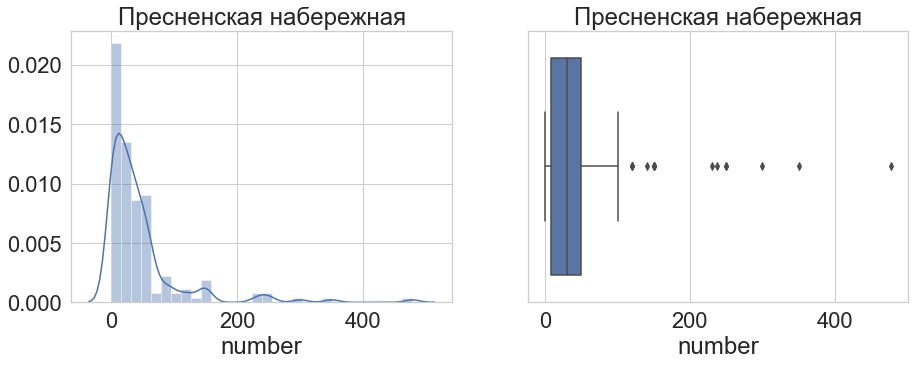

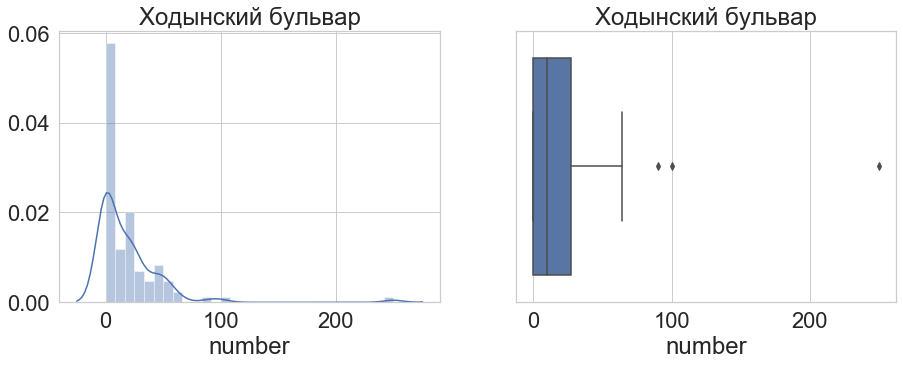

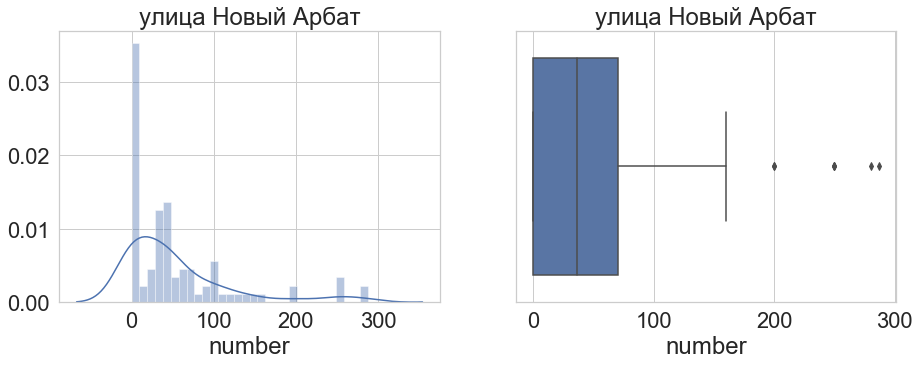

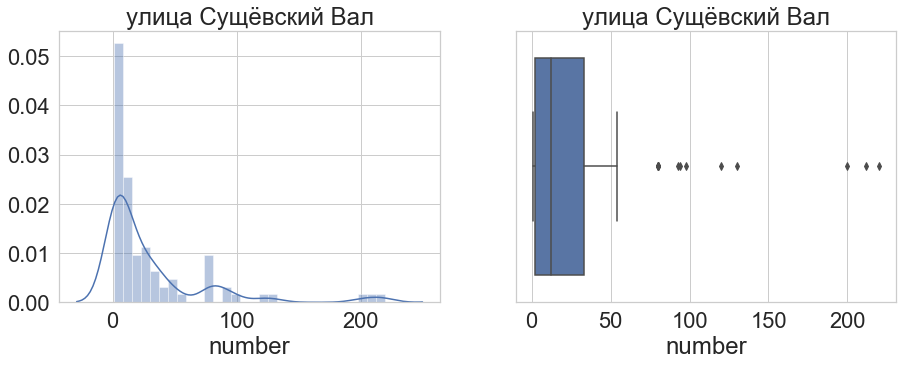

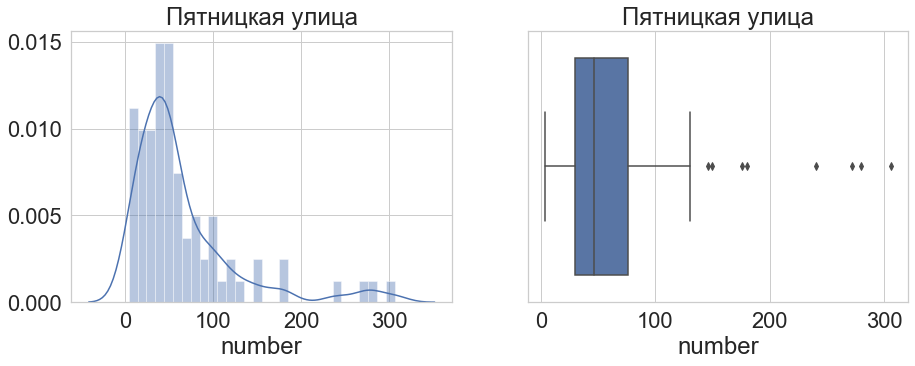

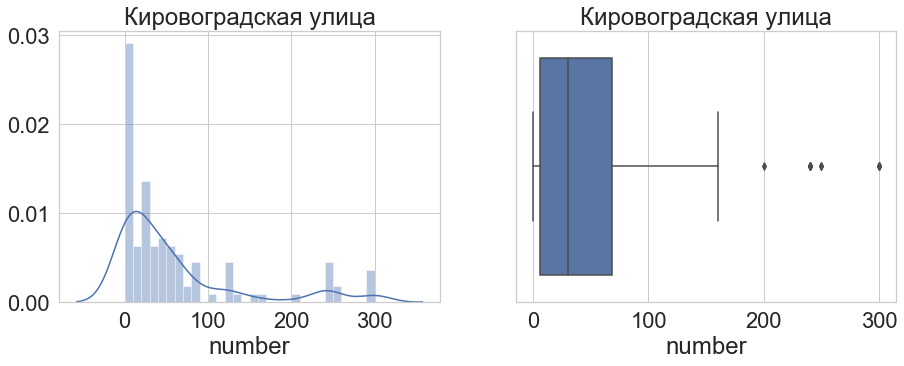

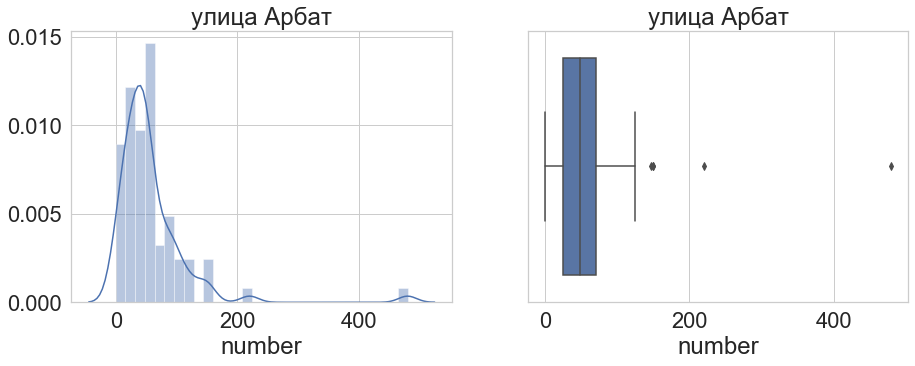

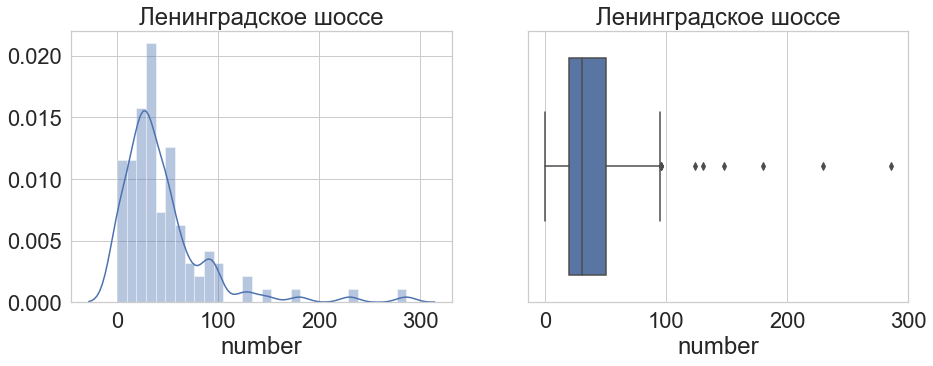

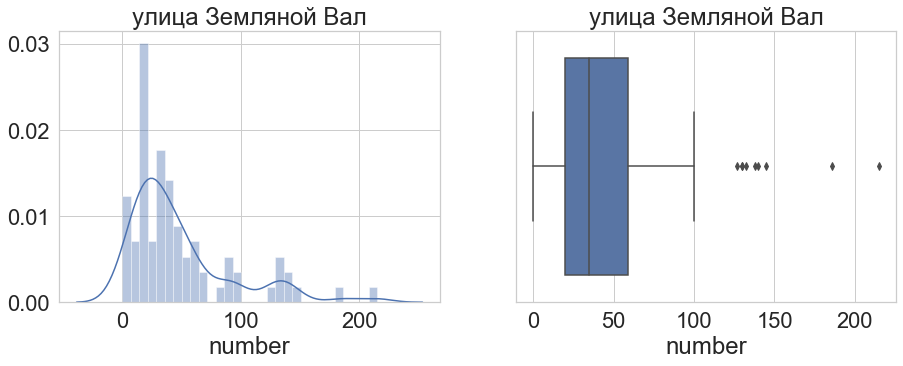

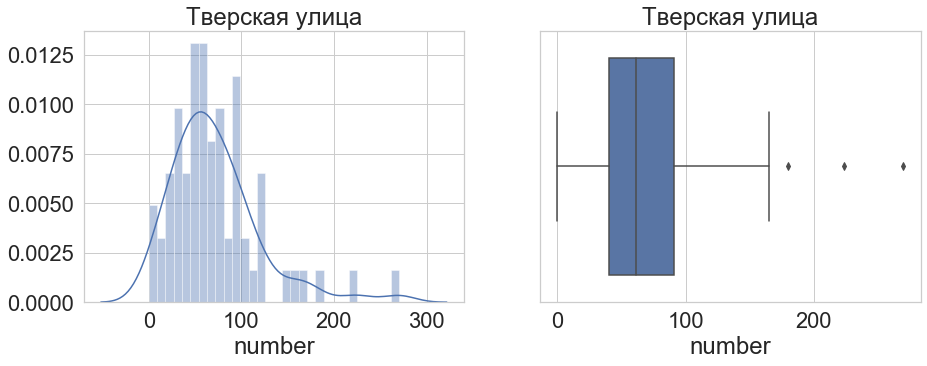

In [36]:
for street in top10streets:
    data = rest_data_new[rest_data_new['street'] == street]
    fig, ax = plt.subplots(nrows=1, ncols=2,  figsize = (15,5))
    sns.distplot(data['number'], bins=30,ax = ax[0]).set_title(str(street))
    sns.boxplot(data['number'], ax = ax[1]).set_title(str(street))
    plt.show()

In [37]:
for street in top10streets:
    data = rest_data_new[rest_data_new['street'] == street]
    print(str(street))
    print(data['number'].describe())

Пресненская набережная
count    167.000000
mean      45.844311
std       65.316834
min        0.000000
25%        8.500000
50%       30.000000
75%       50.000000
max      478.000000
Name: number, dtype: float64
Ходынский бульвар
count    102.000000
mean      18.950980
std       31.224951
min        0.000000
25%        0.000000
50%       10.000000
75%       27.000000
max      250.000000
Name: number, dtype: float64
улица Новый Арбат
count     92.000000
mean      54.184783
std       67.927714
min        0.000000
25%        0.000000
50%       36.000000
75%       70.000000
max      287.000000
Name: number, dtype: float64
улица Сущёвский Вал
count     86.000000
mean      30.651163
std       45.639448
min        1.000000
25%        2.000000
50%       12.000000
75%       33.000000
max      220.000000
Name: number, dtype: float64
Пятницкая улица
count     80.000000
mean      64.850000
std       61.940171
min        4.000000
25%       30.000000
50%       46.500000
75%       76.250000
max      

### Вывод

Больше всего посадочных мест на Тверской, Пятницкой улицах и Арбате, на этих улицах концентрируются крупные рестораны. На Ходынском бульваре и Сущёвском Вале преимущественно располагаются  совсем небольшие заведения, где в среднем чуть больше 10 посадочных мест. В нашем случае маленькое заведение не окупит затраты на роботов, а большое потребует слишком больших инвестиций на старте. Мы хотим открыть заведение среднего размера на 30-40 посетителей, обслуживать которых будет 6 роботов.

## <a id="step3">Презентация</a>

Презентация: https://drive.google.com/file/d/1Mupm9w5GPRAL8fgvjQsle83PLGHe8dQQ/view?usp=sharing